* PAWS reference: https://arxiv.org/pdf/2104.13963.pdf
* Code reference: 
    * https://github.com/ayulockin/SwAV-TF/blob/master/initial_notebooks/Building_MultiCropDataset.ipynb
    * https://github.com/szacho/augmix-tf

In [10]:
!pip install -q tensorflow_addons

     |████████████████████████████████| 706kB 5.8MB/s 


In [1]:
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

In [2]:
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")

Total training examples: 50000


From the PAWS paper:

> The two large-crops (global views) are generated with scale (0.75, 1.0), and the six small-crops (local views) are generated with scale (0.3, 0.75).

In [3]:
BS = 64
SIZE_CROPS = [32, 18] # 32: global views, 18: local views
NUM_CROPS = [2, 6]
GLOBAL_SCALE = [0.75, 1.0] 
LOCAL_SCALE = [0.3, 0.75]
AUTO = tf.data.AUTOTUNE

## Multi-crop augmentation

In [4]:
@tf.function
def float_parameter(level, maxval):
    return tf.cast(level * maxval / 10.0, tf.float32)


@tf.function
def sample_level(n):
    return tf.random.uniform(shape=[1], minval=0.1, maxval=n, dtype=tf.float32)


@tf.function
def solarize(image, level=6):
    threshold = float_parameter(sample_level(level), 1)
    return tf.where(image < threshold, image, 255 - image)


@tf.function
def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    """
    Randomly applies color distortion.

    :param x: input image (h x w x nb_channels)
    :param strength: strength of distortions
    :return: distorted image
    """
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    x = tf.clip_by_value(x, 0, 255)
    return x


@tf.function
def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


@tf.function
def random_resize_distort_crop(image, scale, crop_size):
    # Conditional resizing
    if crop_size == 32:
        image_shape = 48
        image = tf.image.resize(image, (image_shape, image_shape))
    else:
        image_shape = 24
        image = tf.image.resize(image, (image_shape, image_shape))
    # Get the crop size for given scale
    size = tf.random.uniform(
        shape=(1,),
        minval=scale[0] * image_shape,
        maxval=scale[1] * image_shape,
        dtype=tf.float32,
    )
    size = tf.cast(size, tf.int32)[0]
    # Get the crop from the image
    crop = tf.image.random_crop(image, (size, size, 3))
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))

    # Flip and color distortions
    image = tf.image.random_flip_left_right(crop_resize)
    image = random_apply(color_jitter, crop_resize, p=0.8)
    image = random_apply(solarize, crop_resize, p=0.8)
    image = random_apply(tfa.image.equalize, crop_resize, p=0.8)
    return image

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train)

In [6]:
trainloaders = tuple()
for i, num_crop in enumerate(NUM_CROPS):
    for _ in range(num_crop):
        if SIZE_CROPS[i] == 32:
            scale = GLOBAL_SCALE
        elif SIZE_CROPS[i] == 18:
            scale = LOCAL_SCALE
        
        trainloader = (
            train_ds
            .map(lambda x: random_resize_distort_crop(x, scale, SIZE_CROPS[i]), 
                 num_parallel_calls=AUTO, deterministic=True)
        )
        trainloaders += (trainloader,)

In [7]:
# Zipping 
final_trainloader = tf.data.Dataset.zip(trainloaders)

# Final trainloader
final_trainloader = (
    final_trainloader
    .shuffle(BS * 100)
    .batch(BS)
    .prefetch(AUTO)
)

In [8]:
# Shape verfiication
im1, im2, im3, im4, im5, im6, im7, im8 = next(iter(final_trainloader))
print(im1.shape, im2.shape, im3.shape, im4.shape, im5.shape, im6.shape, im7.shape, im8.shape)

(64, 32, 32, 3) (64, 32, 32, 3) (64, 18, 18, 3) (64, 18, 18, 3) (64, 18, 18, 3) (64, 18, 18, 3) (64, 18, 18, 3) (64, 18, 18, 3)


**Visual inspection.** 

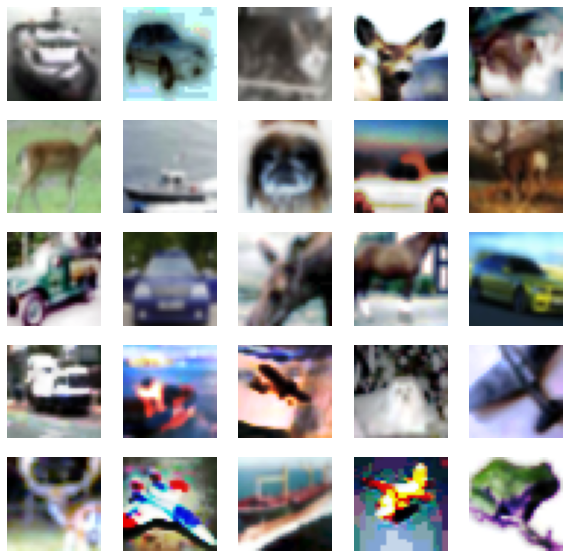

In [9]:
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(im1[n].numpy().astype("int"))
    plt.axis("off")

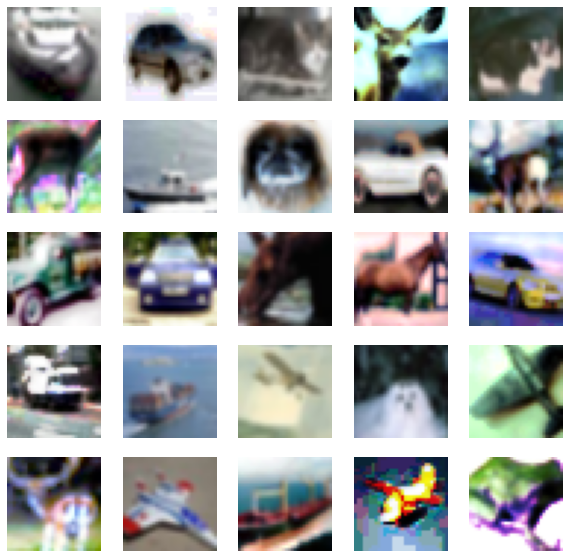

In [10]:
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(im2[n].numpy().astype("int"))
    plt.axis("off")

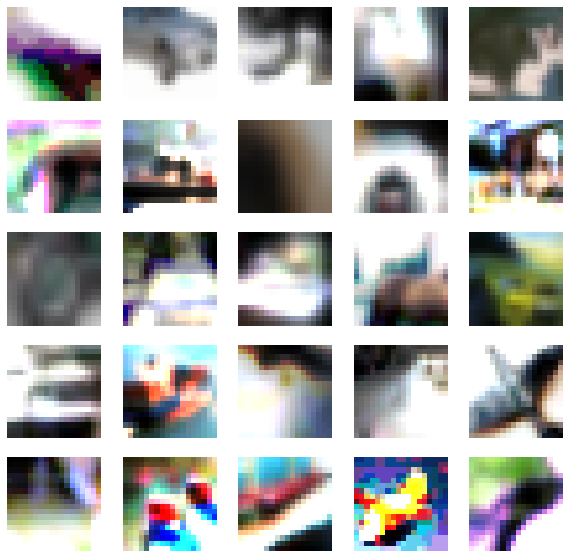

In [11]:
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(im3[n].numpy().astype("int"))
    plt.axis("off")

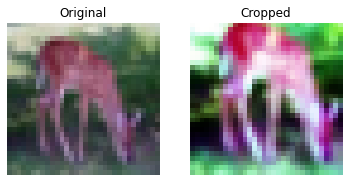

In [12]:
idx = np.random.choice(len(x_train))
one_image = x_train[idx]
cropped_distorted = random_resize_distort_crop(one_image, GLOBAL_SCALE, crop_size=32)

_, ax = plt.subplots(ncols=2, nrows=1)
ax[0].axis("off")
ax[1].axis("off")
ax[0].imshow(one_image)
ax[1].imshow(cropped_distorted.numpy().astype("int"))
ax[0].set_title("Original")
ax[1].set_title("Cropped")

plt.show()

## Sampling of labeled samples

From the paper:

>  We first pre-train a network using PAWS on CIFAR10 **with access to 4000 labels** [...] To construct the support mini-batch at each iteration, we also **randomly sample 640 images, comprising 10 classes and 64 images per class**, from the labeled set [...]

In [13]:
SUPPORT_BS = 640

In [27]:
sampled_idx = np.random.choice(len(x_train), 4000)
sampled_train, sampled_labels = x_train[sampled_idx], y_train[sampled_idx].squeeze()
support_ds = tf.data.Dataset.from_tensor_slices((sampled_train, sampled_labels))
print(sampled_train.shape, sampled_labels.shape)

(4000, 32, 32, 3) (4000,)


In [28]:
def support_sampler(ds):
    ds_list = []
    for i in np.arange(0, 10):
        ds_label = ds.filter(lambda image, label: label == i).repeat()
        ds_list.append(ds_label)
    return ds_list

In [33]:
def get_support_ds(ds, bs, aug=True):
    # Since at each iteration the support dataset should have equal number
    # of images per class we assign uniform weights for sampling.
    listed_ds = support_sampler(ds)
    balanced_ds = tf.data.experimental.sample_from_datasets(listed_ds, [0.1] * 10)

    # As per Appendix C, for CIFAR10 2x views are needed for making
    # the network better at instance discrimination.
    loaders = tuple()
    for _ in range(2):
        if aug:
            loader = balanced_ds.map(
                lambda x, y: (
                    random_resize_distort_crop(x, GLOBAL_SCALE, 32),
                    y,
                ),
                num_parallel_calls=AUTO,
                deterministic=True,
            )
        else:
            loader = balanced_ds
        loaders += (loader, )

    final_ds = tf.data.Dataset.zip(loaders)
    return final_ds.batch(bs)

In [34]:
sample_support_ds = get_support_ds(support_ds, bs=SUPPORT_BS, aug=True)
support_images_one, support_images_two = next(iter(sample_support_ds))
print(support_images_one[0].shape, support_images_one[1].shape, support_images_two[0].shape)

(640, 32, 32, 3) (640,) (640, 32, 32, 3)


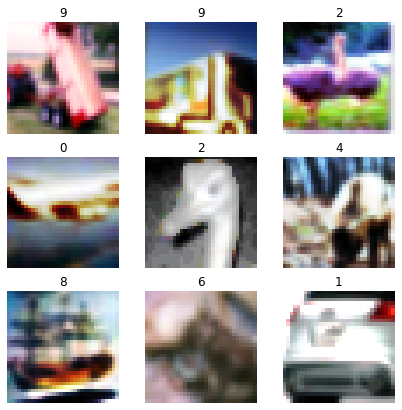

In [35]:
plt.figure(figsize=(7, 7))
for i, image in enumerate(support_images_one[0][:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.title(int(support_images_one[1][i]))
    plt.axis("off")

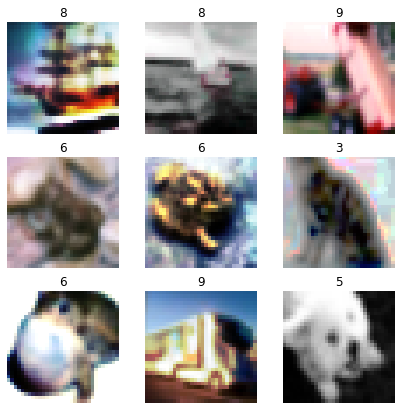

In [36]:
plt.figure(figsize=(7, 7))
for i, image in enumerate(support_images_two[0][:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.title(int(support_images_two[1][i]))
    plt.axis("off")